In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
# from PIL import Image

# To prevent CUBLAS_STATUS_ALLOC_FAILED problem in tensorflow 2, the follwing codes are necessary.

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## DAEs (Denoising Autoencoders)

Imagine that the MNIST digit images were corrupted by noise, thus making it harder for humans to read. We're able to build a denoising autoencoder (DAE) to remove the noise from these images.

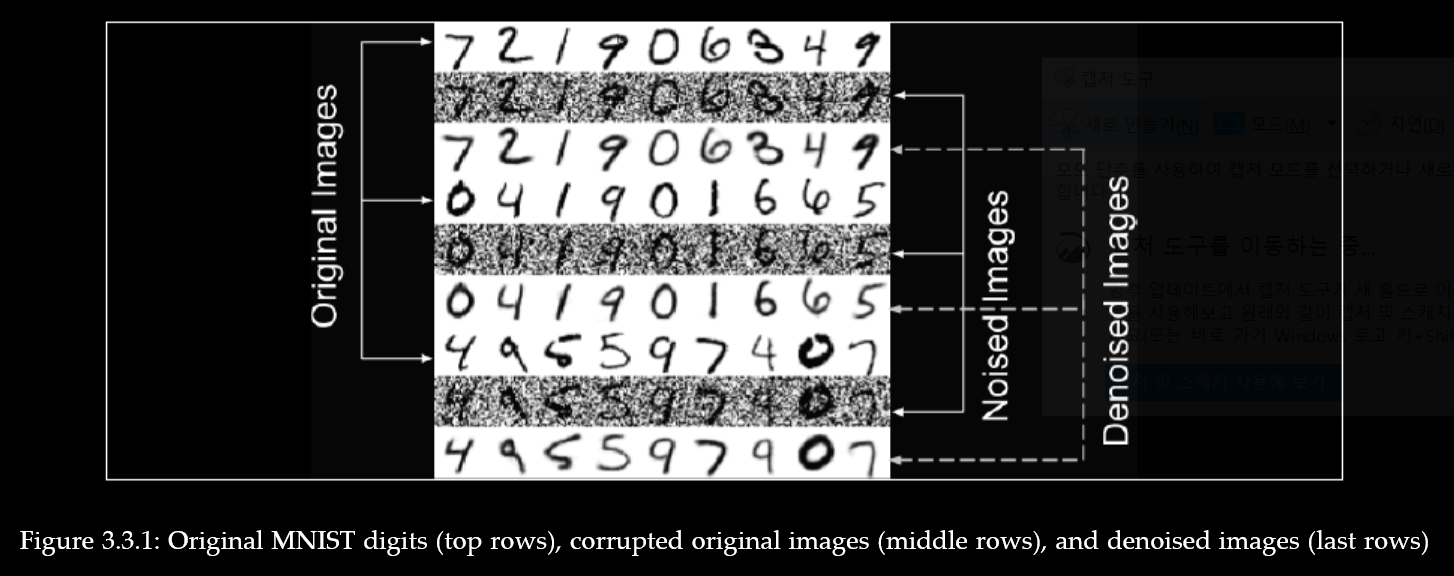

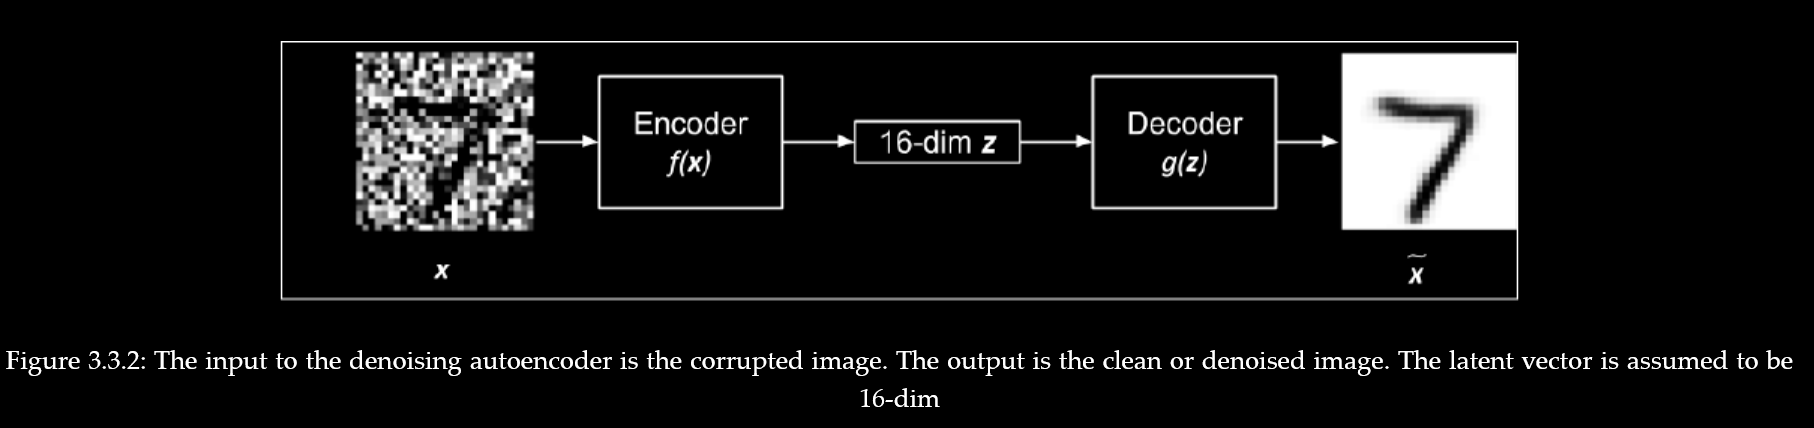

To implement theDAE, we're going to need to make a few changes to the autoencoder presented in 'Autoencoder with mnist'. Firstly, __the training input data should be corrupted MNIST digits.__ The training output data is the same original clean MNIST digits. This is like telling the autoencoder what the corrected images should be or asking it to figure out how to remove noise given a corrupted image. Lastly, we must validate the autoencoder on the corrupted MNIST test data.


In [2]:
np.random.seed(1337)

In [3]:
# Step 1: Data Preparation

(x_train, _),(x_test, _) = mnist.load_data()

image_size = x_train.shape[1]
# Reshape for Conv2D

x_train= np.reshape(x_train,[-1, image_size,  image_size,1]) 
x_test = np.reshape(x_test,[-1, image_size,  image_size,1])

# Normalization

x_train = x_train/255.
x_test = x_test/255.       

# Generate corrupted MNIST images by adding noise with normal distribution N(0.5, 0.5)

noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train+noise

noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test+noise

# adding noise may exceed normalized pixel values>1.0 or <0.0
# clip pixel values >1.0 to 1.0 and <0.0 to 0.0

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [4]:
# Step 2: DAE(Denoising Autoencoder) Model Construction

# Set hyperparameters

input_shape=(image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
layer_filters = [32, 64] # encoder/decoder number of CNN layers and filters per layer

# Build the encoder model

inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# stack of Conv2d(32)-Conv2D(64)

for filters in layer_filters:
    x = Conv2D(filters = filters,
               kernel_size=kernel_size,
               strides = 2,
               activation='relu',
              padding='same') (x)

shape = K.int_shape(x) # Remember that the input to the decoder's first Conv2DTranspose will have this shape.
                       # That is, the shape is (7, 7, 64) which can be processed by the decoder back to (28, 28, 1)

# Generate the latent vector

x = Flatten() (x)
latent = Dense(latent_dim, name='latent_vector') (x)

# Instantiate encoder model

encoder = Model(inputs, latent, name = 'encoder') 
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Build the decoder model.

latent_inputs = Input(shape=(latent_dim,), name='decoder_input')

# Now  use the shape (7, 7, 64) that was earlier saved

x = Dense(shape[1] * shape[2] * shape[3] ) (latent_inputs)

# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)

for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters = filters,
                        kernel_size = kernel_size,
                        strides = 2,
                        activation = 'relu',
                        padding='same') (x)

# Reconstruct the denoised input

outputs = Conv2DTranspose(filters = 1,
                          kernel_size=kernel_size,
                          padding='same',
                          activation='sigmoid',
                          name = 'decoder_output') (x)

# instantiate the decoder model

decoder = Model(latent_inputs, outputs, name = 'decoder')

decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 16)]              0         
_________________________________________________________________
dense (Dense)                (None, 3136)              53312     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_____________________________________________________

In [6]:
# instantiate the autoencoder model

autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")

autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 16)                69008     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Step 3: Model Compile 

autoencoder.compile(loss='mse', optimizer = 'adam')

In [8]:
# Step 4: Model fit

autoencoder.fit(x_train_noisy,
                x_train,
                validation_data = (x_test_noisy, x_test),
                epochs = 10,
                batch_size=batch_size)

Epoch 1/10
1875/1875 [==============================] - 11s 5ms/step - loss: 0.0546 - val_loss: 0.0199
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0194 - val_loss: 0.0178
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0177 - val_loss: 0.0171
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0168 - val_loss: 0.0167
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0162 - val_loss: 0.0162
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0158 - val_loss: 0.0159
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0155 - val_loss: 0.0158
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0152 - val_loss: 0.0159
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0151 - val_loss: 0.0157
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.01

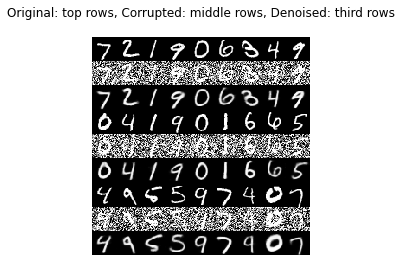

In [11]:
# Step 5: Model evaluation and prediction

x_decoded = autoencoder.predict(x_test_noisy)

# 3 sets of images with 9 MNIST digits
# 1st rows - original images
# 2nd rows - images corrupted by noise
# 3rd rows - denoised images
rows, cols = 3, 9
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original: top rows, '
          'Corrupted: middle rows, '
          'Denoised: third rows\n')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('corrupted_and_denoised.png')
#Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()

## Review

Using the same MNIST dataset, we're able to simulate corrupted images by adding random noise. The noise added is a Gaussian distribution with a mean of image and a standard deviation of image . Since adding random noise may push the pixel data into invalid values of less than 0 or greater than 1, the pixel values are clipped to the [0.1, 1.0] range.

Note that the number of epochs for training has increased to 10. This is to allow sufficient parameter optimization.

Figure 3.3.3 shows a certain level of robustness of the DAE as the level of noise is increased from image to image and image . At image , the DAE is still able to recover the original images. However, at image , a few digits, such as 4 and 5 in the second and third sets, can no longer be recovered correctly.

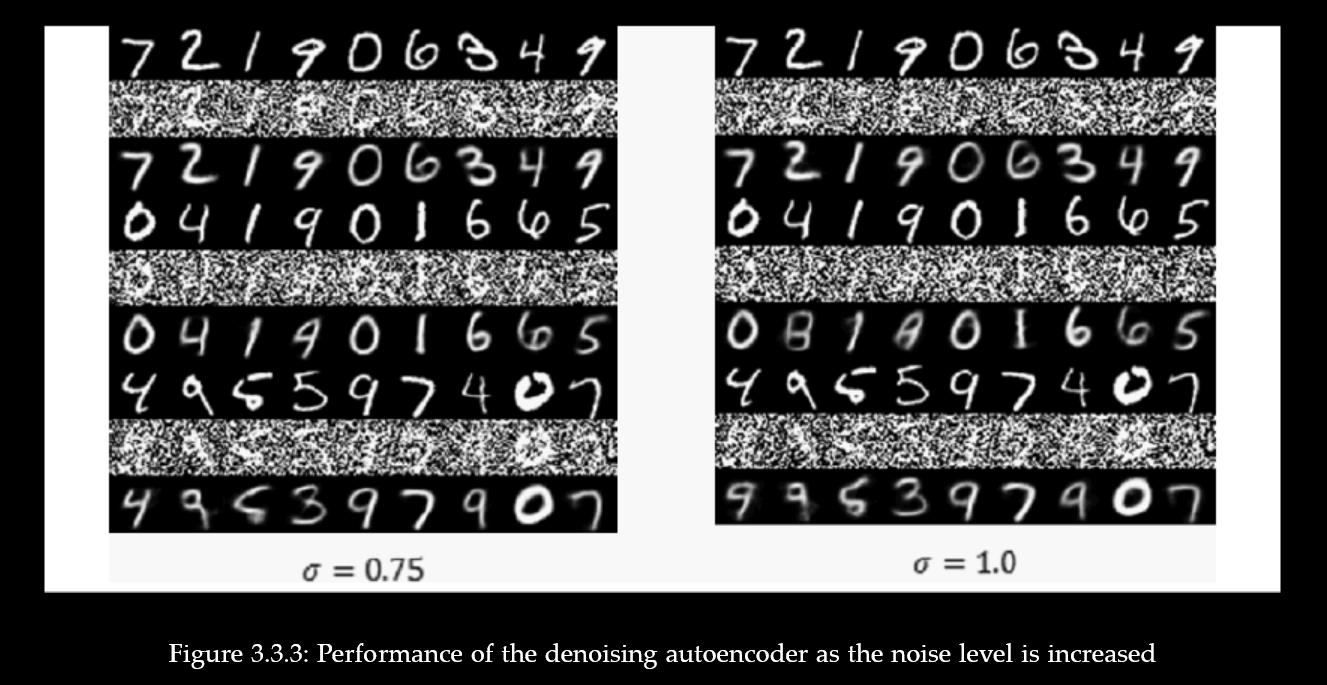

Although the concept was demonstrated on MNIST digits, the idea is applicable to other signals as well.